In [698]:
import numpy as np
import cv2, math, time
from matplotlib import pyplot as plt

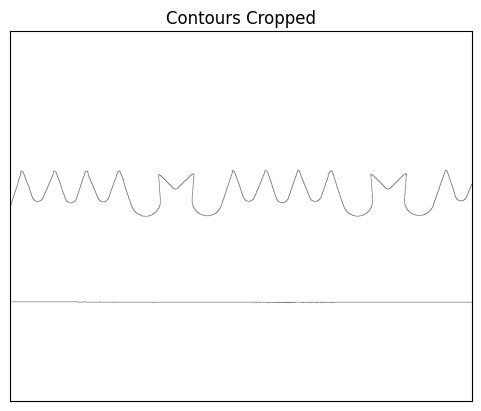

In [699]:
img = cv2.imread("Images\saw_07.png", 0)

ret,img_thresholded = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
img_contours = img_thresholded - cv2.erode(img_thresholded, kernel)     # Contours are white, background is black
img_contours_negative = 255 - img_contours                              # Contours are black, background is white

img_cc = img_contours_negative[:,:]
plt.imshow(img_cc, cmap = 'gray')
plt.title('Contours Cropped')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite("Images\saw_01_contours_cropped.png", img_cc)
raw_contour = [[i,j] for i in range(img_cc.shape[0]) for j in range(img_cc.shape[1]) if img_cc[i,j] == 0]

In [700]:
## Gif of the contours being drawn, order of the points drawn is the order of the list raw_contours (from top to bottom)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in raw_contours:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [701]:
def sort_contour_points(points, neighborhood_dimension, delta_bl=5):

    points = sorted(points, key=lambda p: p[1])
    # 25 sufficiciently large neighborhood to find the first point of the base line
    for i in points[:25]:
        y_max = 0
        if i[1] == 0 and i[0] > y_max:
            y_max = i[0]
            bl_first_point = i

    base_line = [pnt for pnt in points if bl_first_point[0] - delta_bl < pnt[0] < delta_bl + bl_first_point[0]]
    teeth_profile = [pnt for pnt in points if pnt not in base_line]

    # safety check, to handle cases which teeth_profile is has more than one point with x = 0
    x_0 = sorted([pnt for pnt in teeth_profile if pnt[1] == 0], key=lambda p: p[0], reverse=True)
    if len(x_0) > 1:
        teeth_profile = [pnt for pnt in teeth_profile if pnt[1] != 0]
        teeth_profile = x_0 + teeth_profile
    
    splitted_points = [teeth_profile, base_line]
    sorted_contour = []

    for i in splitted_points:
        sorted_points = i
        partial_sorted_contour = [sorted_points[0]]
        sorted_points.remove(sorted_points[0])    
        
        work_point = partial_sorted_contour[0]

        while sorted_points:
            if len(sorted_points) > neighborhood_dimension:
                euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points[:neighborhood_dimension]]
            else:
                euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points]    

            min_distance = min(euclidean_distances)
            nearest_neighbors = [i for i in range(len(euclidean_distances)) if euclidean_distances[i] == min_distance]

            work_point = sorted_points[nearest_neighbors[0]]

            for i in nearest_neighbors:
                partial_sorted_contour.append(sorted_points[i])

            for i in sorted(nearest_neighbors, reverse=True):
                sorted_points.remove(sorted_points[i])
        
        sorted_contour.append(partial_sorted_contour)

            
    return sorted_contour

#sorted_contour(,): list of lists of points, [[teeth_profile], [base_line]]
sorted_contour = sort_contour_points(raw_contour, neighborhood_dimension=120, delta_bl=30)

In [702]:
# Gif of the contours being drawn, order of the points drawn is the order of the list sorted_contour (from left to right)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in sorted_contour:
#    for j in i:
#        blank[j[0], j[1]] = 0
#        cv2.imshow('image', blank)
#        cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [703]:
def RDP_Algorithm(points, epsilon):
    # get the start and end points
    start = points[0]
    end = points[-1]

    # find distance from other points to line formed by start and end
    dist_point_to_line = DPTL(points, start, end)

    # get the index of the points with the largest distance
    max_value = max(dist_point_to_line)
    max_idx = dist_point_to_line.index(max_value) + 1 #since the first (and the last point) are not included in the calculation

    result = []
    if max_value > epsilon:
        if len(points[:max_idx+1]) == 2:
            result += [list(i) for i in points[:max_idx+1] if list(i) not in result]
        else:
            partial_results_left = RDP_Algorithm(points[:max_idx+1], epsilon)
            result += [list(i) for i in partial_results_left if list(i) not in result]
        if len(points[max_idx:]) == 2:
            result += [list(i) for i in points[max_idx:] if list(i) not in result]
        else:
            partial_results_right = RDP_Algorithm(points[max_idx:], epsilon)
            result += [list(i) for i in partial_results_right if list(i) not in result]
    else:
        result += [points[0], points[-1]]
    
    return result

def DPTL(points, start, end):
    # return a list of distances: distance of each point in points to line formed by start and end
    # compute the angular coefficient and the constant of the line formed by start and end
    # y - mx - q = 0
    a = start[1] - end[1]
    b = end[0] - start[0]
    c = - a*start[0] - b*start[1] 

    return [abs(a*points[i][0]+b*points[i][1]+c)/(math.sqrt(a**2+b**2)) for i in range(1,len(points))]

In [704]:
simplified_teeth_profile = RDP_Algorithm(sorted_contour[0], epsilon = 3.5)
simplified_base_line = RDP_Algorithm(sorted_contour[1], epsilon = 3.5)
simplified_contour = [simplified_teeth_profile, simplified_base_line]

# print them on a blank image
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in simplified_contour[0]:
    blank[i[0], i[1]] = [0,0,255]
for i in simplified_contour[1]:
    blank[i[0], i[1]] = [0,0,255]
cv2.imwrite("Images\saw_01_simplified_contour.png", blank)

def fit_parabola(points):
    points_array = np.array(points)

    x = points_array[:, 1]
    y = points_array[:, 0]

    A = np.column_stack((x**2, x, np.ones_like(x)))
    coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)

    return coeffs[0]

def distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

def segment_contours(points, threshold, min_points):
    segments = []
    i = 0
    while i < len(points):
        close_points = [points[i]]
        for j in range(i,len(points)-1):
            if distance(points[j], points[j+1]) < threshold:
                close_points.append(points[j+1])
            else:
                break
        if len(close_points) >= min_points and fit_parabola(close_points) < 0:
            segments.append(close_points)
            i += len(close_points)
        else:
            segments.append([points[i]])
            i += 1
    return segments

def extract_circular_arcs(segment_points, sorted_contour):
    circular_arcs = []
    for i in segment_points:
        if len(i) > 1:
            circular_arcs.append(sorted_contour[sorted_contour.index(i[0]):sorted_contour.index(i[-1])+1]) #so that the last point is included
    return circular_arcs

def extract_straight_lines(segment_points, sorted_contour):
    straight_lines = []
    start_index = 0
    for i in segment_points:
        if len(i) > 1:
            end_index = sorted_contour.index(i[0])
            if end_index - start_index > 0:
                straight_lines.append(sorted_contour[start_index:end_index])
            start_index = sorted_contour.index(i[-1])+1 #so that the last point is not included since it is included in the circular arc segment
    end_index = len(sorted_contour)
    if end_index - start_index > 0:
        straight_lines.append(sorted_contour[start_index:end_index])
    return straight_lines


#segment_contours(,): list of lists, points of the simplified contour that are close to each other are grouped together in a single list 
#[[1° segment], ..., [n° segment], ...] where: 1° segment: [1° point, ..., n° point], ..., n° segment: [1° point, ..., n° point]
segmented_teeth_contour = segment_contours(simplified_contour[0], threshold=35, min_points=3)

#extract_circular_arcs(,): list of lists, [[1° circular arc], ..., [n° circular arc], ...]
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in extract_circular_arcs(segmented_teeth_contour, sorted_contour[0]):
    for j in i:
        blank[j[0], j[1]] = [0,0,255]
cv2.imwrite("Images\saw_01_circular_arcs.png", blank)


#extract_straight_lines(,): list of lists, [[one tooth], ..., [one M tooth], ...]
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in extract_straight_lines(segmented_teeth_contour, sorted_contour[0]):
    for j in i:
        blank[j[0], j[1]] = [255,0,0]
cv2.imwrite("Images\saw_01_straight_lines.png", blank)

True

In [705]:
#TEST NEW SLIPT FUNCTION
def split_sides(points):
    # Find the index of the point with the maximum distance from the first point
    # Check only points on the left and higher (lower y) with respect to the first point
    dists = [np.hypot(p[0]-points[0][0], p[1]-points[0][1]) for p in points if p[0] < points[0][0]]
    max_index = np.argmax(dists)

    points1 = points[:max_index+1]
    points2 = points[max_index:]

    return points1, points2


def M_troncated(points, tooth_threshold=20):
    if abs(points[1][0] - points[2][0]) > tooth_threshold or abs(points[1][1] - points[2][1]) > tooth_threshold:
        return True
    return False


def split_M_tooth(points, sorted_contour, m_threshold, eps):
    split_pnts = []
    for i in range(len(points)):
        if len(points[i]) == 5:
            h = sorted_contour[sorted_contour.index(points[i][1]):sorted_contour.index(points[i][3])+1]
            
            new_simplified_points = RDP_Algorithm(h,eps)
            new_simplified_points.insert(0, points[i][0])
            new_simplified_points.append(points[i][-1])
            points[i] = new_simplified_points

        j = points[i]
        if len(j) > 5:
            poss_split_pnt = []
            for k in j[2:-2]:
                for p in j:
                    if distance(k, p) < m_threshold:
                        dist = True
                    else:
                        dist = False
                        break
                if dist:
                    dist = False
                    poss_split_pnt.append(k)
            split_pnts.append(poss_split_pnt)
    return split_pnts


def split_curves(points, sorted_contour, m_threshold=70):
    RDP_epsilon = 4 
    simplified_straight_lines = []
    m_split_points = []
    splitted_curves = []

    for i in points:
        simplified_straight_lines.append(RDP_Algorithm(i, epsilon=RDP_epsilon))

    m_split_points = split_M_tooth(simplified_straight_lines, sorted_contour, m_threshold, RDP_epsilon-1)
    
    for j in simplified_straight_lines:
        tooth = []
        if len(j) >= 5:
            this_m_split_points = [p for pnt in m_split_points for p in pnt if p in j]
            split_point_index1 = sorted_contour.index(this_m_split_points[0])
            split_point_index2 = sorted_contour.index(this_m_split_points[1])

            tooth.append(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[1])])
            tooth.append(sorted_contour[sorted_contour.index(j[1]):split_point_index1])
                
            splitted_curves.append(tooth)
            tooth = []
            
            tooth.append(sorted_contour[split_point_index2:sorted_contour.index(j[-2])])
            tooth.append(sorted_contour[sorted_contour.index(j[-2]):sorted_contour.index(j[-1])])
        if 2 < len(j) < 5:
            if M_troncated(j, tooth_threshold=30) and len(j) == 4:
                side1, side2 = split_sides(sorted_contour[sorted_contour.index(j[1]):sorted_contour.index(j[-1])])
                tooth.append(side1)
                tooth.append(side2)
            else:
                side1, side2 = split_sides(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[-1])])
                tooth.append(side1)
                tooth.append(side2)
        
        if tooth:
            splitted_curves.append(tooth)
            
    return splitted_curves


#splitted_curves(): list of lists, [[1° tooth], ..., [1° half of the 1° M tooth], [2° half of the 1° M tooth], ...]
#where [one tooth] is [[1° side of the tooth], [2° side of the tooth]]
splitted_curves = split_curves(extract_straight_lines(segmented_teeth_contour, sorted_contour[0]), sorted_contour[0], m_threshold=90)

In [706]:
#def split_sides(points):
#    # Find the index of the point with the maximum distance from the first point
#    # Check only points on the left and higher (lower y) with respect to the first point
#    dists = [np.hypot(p[0]-points[0][0], p[1]-points[0][1]) for p in points if p[0] < points[0][0]]
#    max_index = np.argmax(dists)
#
#    points1 = points[:max_index+1]
#    points2 = points[max_index:]
#
#    return points1, points2
#
#def M_troncated(points, tooth_threshold=20):
#    if abs(points[1][0] - points[2][0]) > tooth_threshold or abs(points[1][1] - points[2][1]) > tooth_threshold:
#        return True
#    return False
#
##split curves can be optimized...
#def split_curves(points, sorted_contour, m_threshold=70):
#    #TOFIX: the function too much shaped to the saw_01 image 
#    simplified_straight_lines = []
#    m_split_points = []
#    splitted_curves = []
#
#    blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255 ######
#
#    for i in points:
#        simplified_straight_lines.append(RDP_Algorithm(i, epsilon = 4))
#
#    for j in simplified_straight_lines:   ######
#        for i in j: ####
#            blank[i[0], i[1]] = [0,0,255]
#    cv2.imwrite("Images\saw_01_simplified_segmentation.png", blank) #######
#
#    for j in simplified_straight_lines:
#        if len(j) >= 5:
#            poss_split_pnt = []
#            for k in j[2:-2]:
#                for p in j:
#                    if distance(k, p) < m_threshold:
#                        dist = True
#                    else:
#                        dist = False
#                        break
#                if dist:
#                    dist = False
#                    poss_split_pnt.append(k)
#            m_split_points.append(poss_split_pnt)
#    
#    for j in simplified_straight_lines:
#        tooth = []
#        if len(j) >= 5:
#            this_m_split_points = [p for pnt in m_split_points for p in pnt if p in j]
#            if len(this_m_split_points) == 1:
#                split_point_index = sorted_contour.index(this_m_split_points[0])
#
#                tooth.append(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[1])])
#                tooth.append(sorted_contour[sorted_contour.index(j[1]):split_point_index])
#                
#                splitted_curves.append(tooth)
#                tooth = []
#            
#                tooth.append(sorted_contour[split_point_index:sorted_contour.index(j[-2])])
#                tooth.append(sorted_contour[sorted_contour.index(j[-2]):sorted_contour.index(j[-1])])
#            elif len(this_m_split_points) == 2:
#                split_point_index1 = sorted_contour.index(this_m_split_points[0])
#                split_point_index2 = sorted_contour.index(this_m_split_points[1])
#
#                tooth.append(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[1])])
#                tooth.append(sorted_contour[sorted_contour.index(j[1]):split_point_index1])
#                
#                splitted_curves.append(tooth)
#                tooth = []
#            
#                tooth.append(sorted_contour[split_point_index2:sorted_contour.index(j[-2])])
#                tooth.append(sorted_contour[sorted_contour.index(j[-2]):sorted_contour.index(j[-1])])
#        if 2 < len(j) < 5:
#            if M_troncated(j, tooth_threshold=30) and len(j) == 4:
#                side1, side2 = split_sides(sorted_contour[sorted_contour.index(j[1]):sorted_contour.index(j[-1])])
#                tooth.append(side1)
#                tooth.append(side2)
#            else:
#                side1, side2 = split_sides(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[-1])])
#                tooth.append(side1)
#                tooth.append(side2)
#        
#        if tooth:
#            splitted_curves.append(tooth)
#            
#    return splitted_curves
#
#
##splitted_curves(): list of lists, [[1° tooth], ..., [1° half of the 1° M tooth], [2° half of the 1° M tooth], ...]
##where [one tooth] is [[1° side of the tooth], [2° side of the tooth]]
#splitted_curves = split_curves(extract_straight_lines(segmented_teeth_contour, sorted_contour[0]), sorted_contour[0], m_threshold=90)

In [707]:
#To fit a triangle over two sets of points, you can use linear regression to find the best fit line for each set of points. 
#The intersection of these two lines will give you one vertex of the triangle. 

def fit_triangle(points1, points2):
    line1 = np.polyfit([p[1] for p in points1], [p[0] for p in points1], 1)
    line2 = np.polyfit([p[1] for p in points2], [p[0] for p in points2], 1)

    x_intersect = (line2[1] - line1[1]) / (line1[0] - line2[0])
    y_intersect = line1[0] * x_intersect + line1[1]
    vertex = [int(y_intersect), int(x_intersect)] #(y, x) format 

    return vertex, line1, line2

def tooth_angle(points):
    analysis = []
    for i in points:
        v, l1, l2 = fit_triangle(i[0], i[1])
        angle = math.degrees(math.atan(abs((l2[0] - l1[0]) / (1 + l1[0] * l2[0]))))
        analysis.append([i[0],i[1],v,angle])
    return analysis

#blade_inspection: list of lists, [ [[1° side of the 1° tooth], [2° side of the 1° tooth], [vertex of the 1° tooth], angle_of_the_1°_tooth], [...], ... ]
blade_inspection = tooth_angle(splitted_curves)
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
#cv2.line(blank, (simplified_base_line[0][1], simplified_base_line[0][0]), (simplified_base_line[-1][1], simplified_base_line[-1][0]), (255,0,0),1, cv2.LINE_4)
for i in blade_inspection:
    if 37 < i[3] < 42.5:
        for j in i[0]:
            blank[j[0], j[1]] = [0,255,0] #first side
        for j in i[1]:
            blank[j[0], j[1]] = [0,0,255] #second side
        cv2.line(blank, (i[0][0][1], i[0][0][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        cv2.line(blank, (i[1][-1][1], i[1][-1][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        #blank[i[2][0], i[2][1]] = [255,0,0] #vertex
        print("Angle:", i[3])
    else:
        for j in i[0]:
            blank[j[0], j[1]] = [0,0,0] #first side
        for j in i[1]:
            blank[j[0], j[1]] = [0,0,0] #second side
        #cv2.line(blank, (i[0][0][1], i[0][0][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        #cv2.line(blank, (i[1][-1][1], i[1][-1][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        blank[i[2][0], i[2][1]] = [255,0,0] #vertex
        print("Tooth number:", blade_inspection.index(i),"Defective Angle:", i[3])

cv2.imwrite("Images\saw_01_traingle_fit.png", blank)

Angle: 38.304670489043616
Tooth number: 1 Defective Angle: 42.51326940772081
Angle: 40.92075972302057
Angle: 38.76008850162851
Angle: 42.05787422109002
Tooth number: 5 Defective Angle: 42.852679609873626
Angle: 38.244855621935976
Angle: 41.60491722663752
Angle: 40.87136363217453
Angle: 37.71556589648166
Angle: 41.77502127622704
Angle: 42.28330387553243
Angle: 38.31520906181349


True

In [708]:
blade_inspection = tooth_angle(splitted_curves)

blank = img.copy()
for i in blade_inspection:
    if 37 < i[3] < 42.5:
        cv2.line(blank, (i[0][0][1], i[0][0][0]), (i[2][1], i[2][0]), 255, 1, cv2.LINE_4)
        cv2.line(blank, (i[1][-1][1], i[1][-1][0]), (i[2][1], i[2][0]), 255, 1, cv2.LINE_4)
        print("Angle:", i[3])
    else:
        start_point = i[0][0]
        middle_point1 = i[0][int(len(i[0])/2)]
        middle_point2 = i[1][int(len(i[1])/2)]
        end_point = i[1][-1]
        print("Start point:", start_point, "End point:", end_point)
        
        #X over the tooth
        #cv2.line(blank, (start_point[1], start_point[0]), (middle_point2[1], middle_point2[0]), 255, 1, cv2.LINE_4)
        #cv2.line(blank, (middle_point1[1], middle_point1[0]), (end_point[1], end_point[0]), 255, 1, cv2.LINE_4)
        
        #Base Line
        #cv2.line(blank, (start_point[1], start_point[0]), (end_point[1], end_point[0]), 255, 1, cv2.LINE_4)

        #Rectangle over the tooth
        #cv2.line(blank, (start_point[1], start_point[0]), (end_point[1], end_point[0]), 255, 1, cv2.LINE_4)
        #cv2.line(blank, (start_point[1], start_point[0]), (start_point[1], i[2][0]), 0, 1, cv2.LINE_4)
        #cv2.line(blank, (start_point[1], i[2][0]), (end_point[1], i[2][0]), 0, 1, cv2.LINE_4)
        #cv2.line(blank, (end_point[1], i[2][0]), (end_point[1], end_point[0]), 0, 1, cv2.LINE_4)
        
        #Circle over the tooth
        cv2.circle(blank, (i[0][-1][1], i[0][-1][0]), 60, 0, 1)

        print("Tooth number:", blade_inspection.index(i),"Defective Angle:", i[3])

cv2.imwrite("Images\Inspection_Blade_Tool_circle.png", blank)


blank = img.copy()
for i in blade_inspection:
    if 37 < i[3] < 42.5:
        cv2.line(blank, (i[0][0][1], i[0][0][0]), (i[2][1], i[2][0]), 255, 1, cv2.LINE_4)
        cv2.line(blank, (i[1][-1][1], i[1][-1][0]), (i[2][1], i[2][0]), 255, 1, cv2.LINE_4)
    else:
        start_point = i[0][0]
        middle_point1 = i[0][int(len(i[0])/2)]
        middle_point2 = i[1][int(len(i[1])/2)]
        end_point = i[1][-1]
        
        #X over the tooth
        cv2.line(blank, (start_point[1], start_point[0]), (middle_point2[1], middle_point2[0]), 255, 1, cv2.LINE_4)
        cv2.line(blank, (middle_point1[1], middle_point1[0]), (end_point[1], end_point[0]), 255, 1, cv2.LINE_4)
        
        #Base Line
        #cv2.line(blank, (start_point[1], start_point[0]), (end_point[1], end_point[0]), 255, 1, cv2.LINE_4)

        #Rectangle over the tooth
        #cv2.line(blank, (start_point[1], start_point[0]), (end_point[1], end_point[0]), 255, 1, cv2.LINE_4)
        #cv2.line(blank, (start_point[1], start_point[0]), (start_point[1], i[2][0]), 0, 1, cv2.LINE_4)
        #cv2.line(blank, (start_point[1], i[2][0]), (end_point[1], i[2][0]), 0, 1, cv2.LINE_4)
        #cv2.line(blank, (end_point[1], i[2][0]), (end_point[1], end_point[0]), 0, 1, cv2.LINE_4)
        
        #Circle over the tooth
        #cv2.circle(blank, (i[0][-1][1], i[0][-1][0]), 60, 0, 1)

        print("Tooth number:", blade_inspection.index(i),"Defective Angle:", i[3])

cv2.imwrite("Images\Inspection_Blade_Tool_X.png", blank)

Angle: 38.304670489043616
Start point: [464, 89] End point: [461, 152]
Tooth number: 1 Defective Angle: 42.51326940772081
Angle: 40.92075972302057
Angle: 38.76008850162851
Angle: 42.05787422109002
Start point: [437, 459] End point: [481, 506]
Tooth number: 5 Defective Angle: 42.852679609873626
Angle: 38.244855621935976
Angle: 41.60491722663752
Angle: 40.87136363217453
Angle: 37.71556589648166
Angle: 41.77502127622704
Angle: 42.28330387553243
Angle: 38.31520906181349
Tooth number: 1 Defective Angle: 42.51326940772081
Tooth number: 5 Defective Angle: 42.852679609873626


True

In [709]:
def tooth_deviation(analyzed_tooth):
    dev = max(DPTL(analyzed_tooth[0], analyzed_tooth[0][0], analyzed_tooth[2]))
    dev = max(dev, max(DPTL(analyzed_tooth[1], analyzed_tooth[1][-1], analyzed_tooth[2])))
    return dev

for i in blade_inspection:
    deviation = round(tooth_deviation(i))
    if deviation > 5:
        print("Tooth number:", blade_inspection.index(i), "Defective Tooth")
    else:
        print("Tooth number:", blade_inspection.index(i), "\tMax deviation:", deviation)

Tooth number: 0 	Max deviation: 2
Tooth number: 1 	Max deviation: 4
Tooth number: 2 	Max deviation: 3
Tooth number: 3 	Max deviation: 3
Tooth number: 4 	Max deviation: 2
Tooth number: 5 	Max deviation: 3
Tooth number: 6 	Max deviation: 2
Tooth number: 7 	Max deviation: 2
Tooth number: 8 	Max deviation: 2
Tooth number: 9 	Max deviation: 3
Tooth number: 10 	Max deviation: 3
Tooth number: 11 	Max deviation: 4
Tooth number: 12 	Max deviation: 3
